In [50]:
from wordcloud import WordCloud, ImageColorGenerator
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from nltk import PorterStemmer
from nltk.corpus import stopwords
import math
import json
from collections import defaultdict
import pickle
from array import array
from heapq import heappush, heappushpop, heappop
from gensim.models import Word2Vec
import scipy.cluster.hierarchy as sch

In [2]:
# %load /home/ivan/Documents/upf/inforetrieval/finalproject/information_retrieval_final_project/search-engine/tweet.py

class Tweet:
    def __init__(self, id, text, user, date, url,
                 hashtags, likes, retweets, terms):
        self.id = id
        self.text = text
        self.user = user
        self.date = date
        self.url = url
        self.hashtags = hashtags
        self.likes = likes
        self.retweets = retweets
        self.terms = terms

    def get_terms(self):
        return self.terms

    @staticmethod
    def from_json(json_str):
        tweet_json = json.loads(json_str)
        return Tweet(
            tweet_json['ID'], tweet_json['Tweet_text'], tweet_json['UserId'],
            tweet_json['Date'], tweet_json['URL'], tweet_json['Hashtags'],
            tweet_json['Likes'], tweet_json['Number_Retweets'], tweet_json['terms']
        )

    def to_json(self):
        return {
            'ID': self.id,
            'Tweet_text': self.text,
            'UserId': self.user,
            'Date': self.date,
            'URL': self.url,
            'Hashtags': self.hashtags,
            'Likes': self.likes,
            'Number_Retweets': self.retweets,
            'terms': self.terms
        }

    def tf_idf_score(self, index):
        tweet_v = []
        tweet_tf = index.get_tf(self, self.id)
        idfs = index.get_idf(self)
        for i in range(len(query_tf)):
            tweet_v.append(tweet_tf[i] * idfs[i])
            query_v.append(query_tf[i] * idfs[i])

    def __str__(self):
        pass


In [3]:
# %load /home/ivan/Documents/upf/inforetrieval/finalproject/information_retrieval_final_project/search-engine/utils.py


def get_terms(line):
    """
    Preprocess the article text (title + body) removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.

    Argument:
    line -- string (text) to be preprocessed

    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """

    stemming = PorterStemmer()
    stops = set(stopwords.words("english"))
    ## START CODE
    line = line.lower()  ## Transform in lowercase
    line = re.sub(r'http\S+', '', line)
    line = re.sub(r'&amp', '', line)
    line = re.sub(r'\d+', '', line)
    line = re.sub(r'\W', ' ', line)
    line = line.split()  ## Tokenize the text to get a list of terms
    line = [word for word in line if word not in stops]  ##eliminate the stopwords (HINT: use List Comprehension)
    line = [stemming.stem(word)
            for word in line]  ## perform stemming (HINT: use List Comprehension)
    ## END CODE
    return line

In [4]:
# %load /home/ivan/Documents/upf/inforetrieval/finalproject/information_retrieval_final_project/search-engine/query.py

class Query:
    def __init__(self, query_text):
        self.text = query_text
        self.terms = get_terms(self.text)
        self.tf = {}
        for term in self.terms:
            if term not in self.tf:
                self.tf[term] = 0
            self.tf[term] += 1

    def get_terms(self):
        return list(self.tf.keys())

    def get_tf(self):
        return list(self.tf.values())

In [5]:
# %load /home/ivan/Documents/upf/inforetrieval/finalproject/information_retrieval_final_project/search-engine/index.py


class Index:

    def __init__(self):
        self.index= None # term --> tweet
        self.tf = None
        self.df = None
        self.tweets = {}
        self.term_id = {}
        self.max_fav = 0
        self.max_rt = 0

    def load_json_tweets(self, file):
        with open(file, 'r') as fp:
            self.create_index(fp.readlines())

    def save(self, path):
        with open(path, 'wb') as fp:
            pickle.dump(self, fp)

    @staticmethod
    def load(path):
        with open(path, 'rb') as fp:
            index = pickle.load(fp)
        return index

    def create_index(self, lines):
        """
        Impleent the inverted index
        
        Argument:
        lines -- collection of tweets
        
        Returns:
        index - the inverted index (implemented through a python dictionary) containing terms as keys and the corresponding 
        list of tweets these keys appears in (and the positions) as values.
        """


        index=defaultdict(list)
        tf = defaultdict(dict)
        df = defaultdict(int)

        for line in lines: # Remember, lines contain all tweets, each line is a tweet
            tweet_json = json.loads(line)
            tweet = Tweet(
                tweet_json['ID'], tweet_json['Tweet_text'], tweet_json['UserId'],
                tweet_json['Date'], tweet_json['URL'], tweet_json['Hashtags'],
                tweet_json['Likes'], tweet_json['Number_Retweets'], tweet_json['terms']
            )
            if tweet.id in self.tweets:
                continue
            self.tweets[tweet.id] = tweet
            tweet_id = tweet.id #tweet id
            terms = tweet.terms #page_title + page_text
            self.max_fav = max(self.max_fav, tweet.likes)
            self.max_rt = max(self.max_rt, tweet.retweets)
            #title = line_arr[1]            
            #titleIndex[page_id]=title  ## we do not need to apply get terms to title because it used only to print titles and not in the index
            
            ## ===============================================================        
            ## create the index for the current doc and store it in termdictPage
            ## termdictPage ==> { ‘term1’: [currentdoc, [list of positions]], ...,‘termn’: [currentdoc, [list of positions]]}
            
            ## Example: if the curr_doc has id 1 and his text is 
            ## "web retrieval information retrieval":
            
            ## termdictPage ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,3]], ‘information’: [1, [2]]}
            
            ## the term ‘web’ appears in document 1 in positions 0, 
            ## the term ‘retrieval’ appears in document 1 in positions 1 and 3
            ## ===============================================================
            
            termdictTweets={}

            for position, term in enumerate(terms): # terms contains page_title + page_text. Loop over all terms
                if term not in self.term_id:
                    self.term_id[term] = len(self.term_id)
                try:
                    # if the term is already in the index for the current page (termdictPage)
                    # append the position to the corrisponding list
                    
            ## START CODE
                    termdictTweets[term][1].append(position)  
                except:
                    # Add the new term as dict key and initialize the array of positions and add the position
                    termdictTweets[term]=[tweet_id, array('I',[position])] #'I' indicates unsigned int (int in python)
                
            #merge the current page index with the main index
            for termpage, postingpage in termdictTweets.items():
                index[termpage].append(postingpage)

            # normalize term frequencies
            # Compute the denominator to normalize term frequencies (formula 2 above)
            # norm is the same for all terms of a document.
            norm = 0
            for term, posting in termdictTweets.items():
                # posting is a list containing doc_id and the list of positions for current term in current document:
                # posting ==> [currentdoc, [list of positions]]
                # you can use it to inferr the frequency of current term.
                norm += len(posting[1]) ** 2
            norm = math.sqrt(norm)

            # calculate the tf(dividing the term frequency by the above computed norm) and df weights
            for term, posting in termdictTweets.items():
                # append the tf for current term (tf = term frequency in current doc/norm)
                tf[term][posting[0]] = np.round(len(posting[1]) / norm, 4) ## SEE formula (1) above
                # increment the document frequency of current term (number of documents containing the current term)
                df[term] += 1  # increment df for current term
            ## END CODE                    
        self.index = index
        self.tf = tf
        self.df = df

    #Given a query (set of words) and and index return the idf of that query
    def get_idf(self, query):
        N=len(self.tweets)
        idf=[]
        query=query.get_terms()
        for term in query:
            df=self.df[term]
            idf.append(math.log(N/df))
        return idf

    #Given a query (set of words) and and index return the total tf of that query 
    def get_tf(self, query, tweet_id):
        query=query.get_terms()
        global_tf_list=[]
        term_list=[]
        for term in query:
            term_list.append(self.tf[term][tweet_id])
        return term_list

    def get_tf_idf_vector(self, tweet_id):
        vector = np.zeros(len(self.index))
        N = len(self.tweets)
        total = 0
        for term in self.tweets[tweet_id].terms:
            tf = self.tf[term].get(tweet_id, 0)
            df = self.df[term]
            tf_idf = tf * math.log(N / df)
            vector[self.term_id[term]] = tf_idf
        norm = np.linalg.norm(vector)
        if norm == 0:
            return None
        return vector / norm

    def get_all_tf_idf(self):
        vectors = np.array([])
        for tweet in self.tweets:
            v = self.get_tf_idf_vector(tweet)
            if isinstance(v, np.ndarray):
                vectors = np.vstack((vectors, v))
            if len(vectors) % 1000 == 0:
                print(len(vectors))
        return vectors

    #Given a query (set of words) return all the tweets containing the query
    def get_tweets(self, query):
        query=query.get_terms()
        list_tweets=set()
        for term in query:
            ## START DODE
            try:
                # store in termDocs the ids of the docs that contain "term"
                termTweets=[posting[0] for posting in self.index[term]]
                # docs = docs Union termDocs
                if len(list_tweets) == 0:
                    list_tweets = list_tweets.union(termTweets)
                else:
                    list_tweets = list_tweets.intersection(termTweets)
            except:
                #term is not in index
                pass
        list_tweets=list(list_tweets)

        tweets_query = [self.tweets[tid] for tid in list_tweets] #asssuming index of tweets is id
        #list of tweets ids
        return tweets_query

    #Given a query (set of words) return the tweets number of tweets containing the query
    def get_num_tweets(self,query):

        num_tweets=len(self.get_tweets(query))

        return num_tweets

    def get_max_fav(self):
        return self.max_fav

    def get_max_rt(self):
        return self.max_rt


In [6]:
# %load /home/ivan/Documents/upf/inforetrieval/finalproject/information_retrieval_final_project/search-engine/score.py

def cosine_similarity(a, b, norm_a=True, norm_b=True):
    total = 0
    sum_a = 0 if norm_a else 1.0
    sum_b = 0 if norm_b else 1.0
    for x, y in zip(a, b):
        total += x * y
        if norm_a:
            sum_a += x * x
        if norm_b:
            sum_b += y * y
    if norm_a:
        sum_a = math.sqrt(sum_a)
    if norm_b:
        sum_b = math.sqrt(sum_b)
    return total / (sum_a * sum_b)

class TfIdfScorer:
    def __init__(self):
        pass
    def score(self, tweet: Tweet, query, index, normalize=True):
        tweet_v = []
        query_v = []
        tweet_tf = index.get_tf(query, tweet.id)
        query_tf = query.get_tf()
        idfs = index.get_idf(query)
        for i in range(len(query_tf)):
            tweet_v.append(tweet_tf[i] * idfs[i])
            query_v.append(query_tf[i] * idfs[i])
        return cosine_similarity(tweet_v, query_v, norm_a=normalize, norm_b=normalize) # assume get_tf normalizes

class CustomScorer:
    W_TFIDF = .5
    W_FAV = .25
    W_RT = .25
    def __init__(self):
        pass

    def score(self, tweet: Tweet, query, index, normalize=True):
        tfidf = TfIdfScorer().score(tweet, query, index, normalize=normalize)
        max_fav = index.get_max_fav()
        max_rt = index.get_max_rt()
        fav_score = math.log(tweet.likes + 1)/(math.log(max_fav + 1) + 1)# TQM
        rt_score = math.log(tweet.retweets + 1)/(math.log(max_rt + 1) + 1)
        score = tfidf * CustomScorer.W_TFIDF + \
                    fav_score * CustomScorer.W_FAV + \
                    rt_score * CustomScorer.W_RT
        return score

class Word2VecScorer:
    def __init__(self, tweets=[], size=100, window=5, min_count=1, epochs=5):
        sentences = [tweet.get_terms() for tweet in tweets]
        self.model = Word2Vec(sentences, size=size, window=window, min_count=min_count, iter=epochs)

    def save(self, path):
        self.model.save(path)

    @staticmethod
    def load(self, path):
        word2vec = Word2VecScorer()
        word2vec.model = Word2Vec.load(path)
        return word2vec

    def get_tweet_vector(self, tweet):
        if len(tweet.get_terms()) == 0:
            return np.zeros(self.model.vector_size)
        return np.mean([self.get_vector(token) for token in tweet.get_terms()], axis=0)

    def get_vector(self, word):
        if word not in self.model.wv.vocab:
            return np.random.uniform(size=len(self.model.vector_size))
        return self.model.wv[word]

    def score(self, tweet, query: Query, index):
        tweet_v = np.mean([self.get_vector(token) for token in tweet.tokens()], axis=0)
        query_v = np.mean([self.get_vector(token) for token in query.get_terms()], axis=0)
        return cosine_similarity(tweet_v, query_v)

class DiversityScore:
    W_SCORE = 0.8
    W_DIV = 0.2
    def __init__(self, base_score):
        self.base_score = base_score

    def get_diversity(self, tweet, index, ranking):
        is_in = tweet.id in {id for _, id in ranking}
        count = (len(ranking) - (1 if is_in else 0))
        if count == 0:
            return 0
        v1 = index.get_tf_idf_vector(tweet.id)
        total = 0
        for _, t in ranking:
            total += cosine_similarity(v1, index.get_tf_idf_vector(t))
        return 1 - (total / count) # if tweet is in ranking, we take mean over len(ranking)-1, otherwise, over all len(ranking)

    def score(self, tweet, query: Query, index, ranking):
        score = self.base_score.score(tweet, query, index)
        diversity = self.get_diversity(tweet, index, ranking)
        return score * DiversityScore.W_SCORE + diversity * DiversityScore.W_DIV

def rank_tweets(query: Query, index, K=20, scorer=None, log=False):
    scorer = scorer if scorer is not None else TfIdfScorer()
    heap = []
    for tweet in index.get_tweets(query):
        score = scorer.score(tweet, query, index)
        if len(heap) < K:
            heappush(heap, (score, tweet.id))
        else:
            heappushpop(heap, (score, tweet.id))
    if log:
        heap2 = list(heap)
        ranking_scores = [heappop(heap2) for _ in range(len(heap2))]
        ranking_scores.reverse()
        for score, tweet in ranking_scores:
            print(score, index.tweets[tweet].text)
    ranking = [heappop(heap)[1] for _ in range(len(heap))]
    ranking.reverse()

    return [index.tweets[tid] for tid in ranking]

def rank_tweets_diversity(query: Query, index, K=20, scorer=None, log=False):

    scorer = scorer if scorer is not None else TfIdfScorer()
    heap = []
    div_score = DiversityScore(scorer)

    def recompute(heap):
        new_heap = []
        for _, t_id in heap:
            new_score = div_score.score(index.tweets[t_id], query, index, heap)
            heappush(new_heap, (new_score, t_id))
        return new_heap

    for tweet in index.get_tweets(query):
        score = div_score.score(tweet, query, index, heap)
        if len(heap) < K:
            heappush(heap, (score, tweet.id))
            heap = recompute(heap)
        else:
            t_out = heappushpop(heap, (score, tweet.id))
            if t_out != tweet.id:
                heap = recompute(heap)
    if log:
        heap2 = list(heap)
        ranking_scores = [heappop(heap2) for _ in range(len(heap2))]
        ranking_scores.reverse()
        for score, tweet in ranking_scores:
            print(score, index.tweets[tweet].text)
    ranking = [heappop(heap)[1] for _ in range(len(heap))]
    ranking.reverse()

    return [index.tweets[tid] for tid in ranking]

In [7]:
index = Index()
index.load_json_tweets('/home/ivan/Documents/upf/inforetrieval/finalproject/information_retrieval_final_project/res/merge_1.json')

In [20]:
dictionaries = []
with open ('/home/ivan/Documents/upf/inforetrieval/finalproject/information_retrieval_final_project/res/merge_1.json','r') as file:
    for line in file: 
        tweet=json.loads(line)
        dictionaries.append(tweet)
df = pd.DataFrame(dictionaries)
        

In [21]:
df.head()

,ID,Tweet_text,UserId,Date,URL,Hashtags,Likes,Number_Retweets,terms
0,1335163929757151232,Create a pandemic BEFORE presidential election...,1257238248,Sat Dec 05 10:07:41 +0000 2020,https://twitter.com/RealRichardBail/status/133...,[],4,4,"[creat, pandem, presidenti, elect, thu, justif..."
1,1335164973396455425,It's quite a big deal that a central religious...,759348635205181440,Sat Dec 05 10:11:50 +0000 2020,https://twitter.com/TheKafkaDude/status/133516...,[],0,0,"[quit, big, deal, central, religi, polit, bodi..."
2,1334864856969859075,Rest In Peace @CharlestonPDWV PO Cassie Johnso...,772529887,Fri Dec 04 14:19:17 +0000 2020,https://twitter.com/bigricanman/status/1334864...,"[BlueLivesMatter, BacktheBlue]",2402,949,"[rest, peac, charlestonpdwv, po, cassi, johnso..."
3,1335164982158364673,@CeeTalking @NMudoliwa Actually I started my o...,275046515,Sat Dec 05 10:11:52 +0000 2020,https://twitter.com/lunchout2/status/133516498...,[],0,0,"[ceetalk, nmudoliwa, actual, start, busi, enab..."
4,1335164991952080896,@ElysianaValenti @CupKatie00 @emilybernay @Rud...,2728145463,Sat Dec 05 10:11:54 +0000 2020,https://twitter.com/joeyp0tato1/status/1335164...,[],0,0,"[elysianavalenti, cupkati, emilybernay, rudygi..."


In [14]:
bag_of_words = {}
for tweet in index.tweets.values():      
    # create bag-of-words - for each word the frequency of the word in the corpus
    for term in tweet.terms:
        if term not in bag_of_words:
            bag_of_words[term] = 0
        bag_of_words[term] +=1

In [15]:
def plot_wordcloud(title, dic_):
    fig, ax = plt.subplots(1, 1, figsize=(18,7))
    wordcloud = WordCloud(background_color="white",width=1600, height=800)
    wordcloud = wordcloud.generate_from_frequencies(dic_)
    ax.axis("off")     
    ax.imshow(wordcloud, interpolation='bilinear')

    ax.set_title(title)
    plt.tight_layout()
    fig.subplots_adjust(top=0.8)
    plt.show()

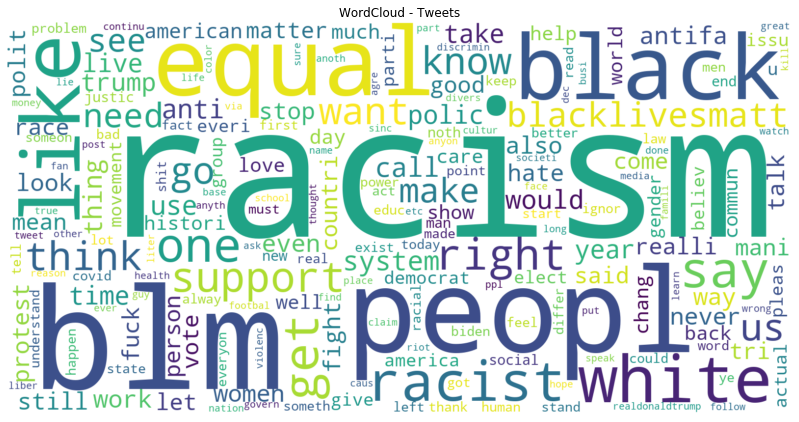

In [16]:
plot_wordcloud("WordCloud - Tweets", bag_of_words) #exclude stopwords,....

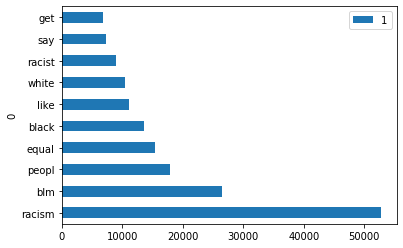

In [19]:
terms_freq=[]
for term in bag_of_words:
    terms_freq.append((term, bag_of_words[term]))
terms_freq.sort(key=lambda x: x[1], reverse=True)

df1=pd.DataFrame(terms_freq[:10])
df1.set_index(0, inplace=True)
df1.plot.barh()
plt.show()


In [7]:
print(len(index.tweets))

10000


In [11]:
word2vec = Word2VecScorer(tweets=list(index.tweets.values()), size=64)

In [61]:
list(tweets.values())[225].text

'This 👇'

In [9]:
#1st Qt - e
tweets= index.tweets
X = [np.array([word2vec.get_tweet_vector(tweet)]) for tweet in tweets.values()]
X = np.concatenate(X, axis=0) #This are tweets word2vec


In [91]:
[tweet.id for tweet in list(tweets.values())[:5]]

[1333663879507955714,
 1333607830176358401,
 1333687122910343169,
 1333355531101229056,
 1333687132439851009]

In [96]:
df['ID'][1]

1.3336078301763584e+18

In [75]:
X.shape

(10000, 256)

In [46]:
type(X)

numpy.ndarray

In [15]:
tsne = TSNE(n_components=2)

In [16]:
tsne.fit(X[:10000])

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
     method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
     n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=30.0,
     random_state=None, verbose=0)

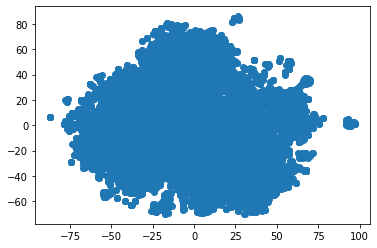

In [31]:
X_embedded = tsne.fit_transform(X[:10000])

plt.scatter(X_embedded[:,0],X_embedded[:,1])


In [40]:
from sklearn.cluster import KMeans, AgglomerativeClustering
import numpy as np

clustering = KMeans(n_clusters=4).fit(X)

#What are the 5 most relevant keywords in the tweets that are part of each
#cluster?
#Calcular para cada cluster el term frequency, devolver

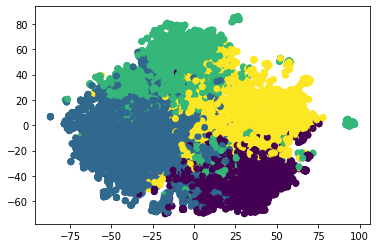

In [41]:
plt.scatter(X_embedded[:,0],X_embedded[:,1], c=clustering.labels_[:10000])

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [10.0, 10.0, 32.5, 32.5],
  [55.0, 55.0, 65.0, 65.0],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [105.0, 105.0, 115.0, 115.0],
  [125.0, 125.0, 135.0, 135.0],
  [110.0, 110.0, 130.0, 130.0],
  [82.5, 82.5, 120.0, 120.0],
  [60.0, 60.0, 101.25, 101.25],
  [21.25, 21.25, 80.625, 80.625],
  [155.0, 155.0, 165.0, 165.0],
  [145.0, 145.0, 160.0, 160.0],
  [175.0, 175.0, 185.0, 185.0],
  [195.0, 195.0, 205.0, 205.0],
  [215.0, 215.0, 225.0, 225.0],
  [200.0, 200.0, 220.0, 220.0],
  [180.0, 180.0, 210.0, 210.0],
  [152.5, 152.5, 195.0, 195.0],
  [235.0, 235.0, 245.0, 245.0],
  [255.0, 255.0, 265.0, 265.0],
  [240.0, 240.0, 260.0, 260.0],
  [285.0, 285.0, 295.0, 295.0],
  [275.0, 275.0, 290.0, 290.0],
  [250.0, 250.0, 282.5, 282.5],
  [173.75, 173.75, 266.25, 266.25],
  [315.0, 315.0, 325.0, 325.0],
  [305.0, 305.0, 320.0, 320.0],
  [355.0, 355.0, 365.0, 365.0],
  [345.0, 345.0, 360.0, 

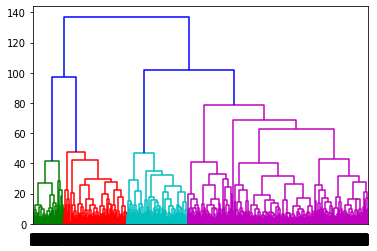

In [38]:
y = sch.ward(X[:10000])
sch.dendrogram(y)

In [42]:

df['cluster'] = clustering.labels_

In [43]:
df.head()

,ID,Tweet_text,UserId,Date,URL,Hashtags,Likes,Number_Retweets,terms,cluster
0,1335163929757151232,Create a pandemic BEFORE presidential election...,1257238248,Sat Dec 05 10:07:41 +0000 2020,https://twitter.com/RealRichardBail/status/133...,[],4,4,"[creat, pandem, presidenti, elect, thu, justif...",0
1,1335164973396455425,It's quite a big deal that a central religious...,759348635205181440,Sat Dec 05 10:11:50 +0000 2020,https://twitter.com/TheKafkaDude/status/133516...,[],0,0,"[quit, big, deal, central, religi, polit, bodi...",1
2,1334864856969859075,Rest In Peace @CharlestonPDWV PO Cassie Johnso...,772529887,Fri Dec 04 14:19:17 +0000 2020,https://twitter.com/bigricanman/status/1334864...,"[BlueLivesMatter, BacktheBlue]",2402,949,"[rest, peac, charlestonpdwv, po, cassi, johnso...",3
3,1335164982158364673,@CeeTalking @NMudoliwa Actually I started my o...,275046515,Sat Dec 05 10:11:52 +0000 2020,https://twitter.com/lunchout2/status/133516498...,[],0,0,"[ceetalk, nmudoliwa, actual, start, busi, enab...",1
4,1335164991952080896,@ElysianaValenti @CupKatie00 @emilybernay @Rud...,2728145463,Sat Dec 05 10:11:54 +0000 2020,https://twitter.com/joeyp0tato1/status/1335164...,[],0,0,"[elysianavalenti, cupkati, emilybernay, rudygi...",0


In [44]:
def plot_cluster_terms(df, cluster):
    bag_of_words = {}
    for list_terms in df[df["cluster"] == cluster]["terms"]:      
        # create bag-of-words - for each word the frequency of the word in the corpus
        for term in list_terms:
            if term not in bag_of_words:
                bag_of_words[term] = 0
            bag_of_words[term] +=1
    terms_freq=[]
    for term in bag_of_words:
        terms_freq.append((term, bag_of_words[term]))
    terms_freq.sort(key=lambda x: x[1], reverse=True)

    df1=pd.DataFrame(terms_freq[:5])
    df1.set_index(0, inplace=True)
    df1.plot.barh()
    plt.show()

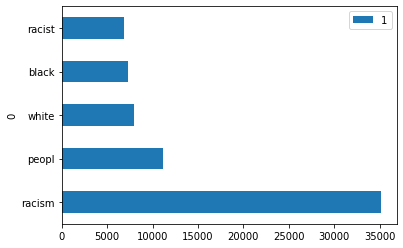

In [45]:
plot_cluster_terms(df, 1)

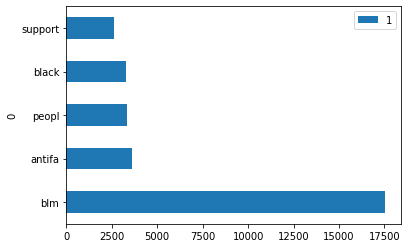

In [46]:
plot_cluster_terms(df, 0)

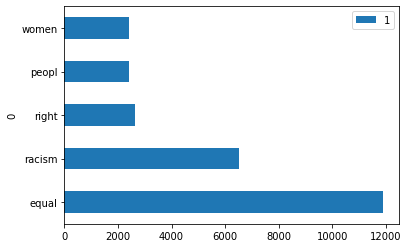

In [47]:
plot_cluster_terms(df, 2)

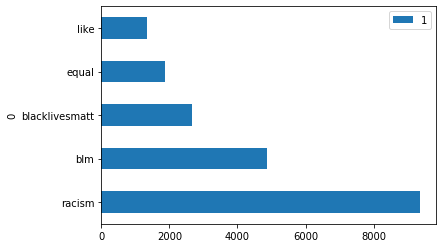

In [48]:
plot_cluster_terms(df, 3)

In [113]:
df[df["cluster"]==1]["Tweet_text"].head()

0     Dankie @AdvDali_Mpofu racism has no place in S...
2     @lidia__thorpe Brilliant Lidia! Right now is e...
7     Ready for India's 1st female superhero? Make w...
15    NEW: Ten local Black Lives Matter chapters hav...
21    Thailand worked hard &amp; fought back COVID-1...
Name: Tweet_text, dtype: object